# 1. Libaries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix, precision_recall_curve, f1_score
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score

In [2]:
TARGET_FEATURE = 'FLAG'

class Ethereum_Fraud_Model:
    """
        Data: 
            - https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset
        
        Notes:
            We can modularize our codes into functions in the en. This is just a 
            placeholder for now.
    """
    
    def __init__(self):
        self.import_data()
        self.preprocess_data()
        self.models = []

    def import_data(self, data_name='ethereum'):
        if data_name == 'ethereum':
            self.df = pd.read_csv('./data/transaction_dataset.csv', index_col=0)
            
    def preprocess_data(self):
        self.filtered_colns = ['Index', 'Address', ' ERC20 most sent token type', ' ERC20_most_rec_token_type']
        pass
    
    def add_model(self, model):
        self.models.append(model)
    
    def run_model(self, model_name):
        for model in self.models:
            if model.get_model_name().upper() == model_name.upper(): # Making it case insensitive
                model.run()
    
    def run_models(self):
        for model in self.models:
            model.run()
        

In [17]:
from sklearn.mixture import GaussianMixture

class GMM_Model():
    """
        Class for GMM Model
    """
    def __init__(self, df):
        self.df = df
        self.preprocess_data()
        self.train, self.valid, self.test = self.spilt_data_3way()
        self.model_name = 'GMM'

    def get_model_name(self):
        return self.model_name

    def preprocess_data(self):
        # QuickFix, Need to update it once data cleaning and preparation step completes
        self.df.fillna(self.df.median(), inplace=True)
        self.normal_data = self.df[self.df[TARGET_FEATURE] == 0]
        self.anomaly_data = self.df[self.df[TARGET_FEATURE] == 1]
    
    # TO-DO: Allow consumer function to split percentages
    def spilt_data_3way(self, normal_data=None, anomaly_data=None):
        if not normal_data:
            normal_data = self.normal_data
        if not anomaly_data:
            anomaly_data = self.anomaly_data
            
        # Spliting Normal data into 80% + 10% + 10%
        train, valid, test = np.split(normal_data.sample(frac=1, random_state=42), [int(.8*len(normal_data)), int(.9*len(normal_data))])
        
        # Splitting Anomaly data into 50% + 50%
        valid_anomaly, test_anomaly = np.split(anomaly_data.sample(frac=1, random_state=42), [int(.5*len(anomaly_data))])
        
        # Combining Validation data and shuffling it
        valid = pd.concat([valid, valid_anomaly]).sample(frac=1)
        
        # Combining Test Data and shuffling it
        test = pd.concat([test, test_anomaly]).sample(frac=1)
        # print('Train shape: ', train.shape)
        # print('Proportion os anomaly in training set: %.3f\n' % train[TARGET_FEATURE].mean())
        # print('Valid shape: ', valid.shape)
        # print('Proportion os anomaly in validation set: %.3f\n' % valid[TARGET_FEATURE].mean())
        # print('Test shape:, ', test.shape)
        # print('Proportion os anomaly in test set: %.3f\n' % test[TARGET_FEATURE].mean())
        return (train, valid, test)
    
    # TO-DO: Break this big function into train, test and evaluate functions
    def run(self, train=None, valid=None, test=None, verbose=False):
        print("Model Name: " + self.get_model_name())
        display(self.df.head())
        if not train:
            train = self.train
        if not valid:
            valid = self.valid
        if not test:
            test = self.test
        for components in range(1, 5):
            print('Components: ' + str(components))
            gmm = GaussianMixture(n_components=components, n_init=4, random_state=42, covariance_type='tied')
            # Train GMM on train data
            gmm.fit(train.drop(TARGET_FEATURE, axis=1).values)
            if verbose:
                print('GMM Score for train set')
                print(gmm.score(train.drop(TARGET_FEATURE, axis=1).values))
                print('GMM Score for normal transcation subset in validation set')
                print(gmm.score(valid[valid[TARGET_FEATURE] == 0].drop(TARGET_FEATURE, axis=1).values))
                print('GMM Score for fraud transcation subset in validation set')
                print(gmm.score(valid[valid[TARGET_FEATURE] == 1].drop(TARGET_FEATURE, axis=1).values))
        
            # Figuring out a threshold range based on GMM score obtained from previous step
            tresholds = np.linspace(-800, 0, 100)
            # gmm.score_samples to calculate a GMM score for each data sample
            y_scores = gmm.score_samples(valid.drop(TARGET_FEATURE, axis=1).values)
            scores = []
            for treshold in tresholds:
                y_hat = (y_scores < treshold).astype(int)
                scores.append([recall_score(y_pred=y_hat, y_true=valid[TARGET_FEATURE].values),
                             precision_score(y_pred=y_hat, y_true=valid[TARGET_FEATURE].values),
                             f1_score(y_pred=y_hat, y_true=valid[TARGET_FEATURE].values)])

            scores = np.array(scores)
            if verbose:
                print(scores[:, 2].max(), scores[:, 2].argmax())
            
            final_tresh = tresholds[scores[:, 2].argmax()]
            if verbose:
                print('The final threshold selected is: ', final_tresh)
            
            y_hat_test = (gmm.score_samples(test.drop(TARGET_FEATURE, axis=1).values) < final_tresh).astype(int)

            # TO-DO: Call defined evaluation functions
            print('Final threshold: %f' % final_tresh)
            print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test[TARGET_FEATURE].values))
            print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test[TARGET_FEATURE].values))
            print('Test F1 Score: %.3f' % f1_score(y_pred=y_hat_test, y_true=test[TARGET_FEATURE].values))

            cnf_matrix = confusion_matrix(test[TARGET_FEATURE].values, y_hat_test)
            print("tn, fp, fn, tp:", cnf_matrix.ravel())
        

In [18]:
from sklearn.cluster import DBSCAN

class DBSCAN_Model():
    def __init__(self, df):
        self.df = df
        self.preprocess_data()
        self.model_name = 'DBSCAN'
        self.n_clusters = 4
    
    def get_model_name(self):
        return self.model_name
    
    def preprocess_data(self):
        # QuickFix, Need to update it once data cleaning and preparation step completes
        self.df.fillna(self.df.median(), inplace=True)
        
    def set_n_clusters(self, n):
        self.n_clusters = n
    
    def run(self):
        nearest_neighbors = NearestNeighbors(n_neighbors=self.n_clusters)
        nearest_neighbors.fit(df)
        distances, indices = nearest_neighbors.kneighbors(df)
        distances = np.sort(distances, axis=0)[:, 1]
        
        plt.plot(distances[9811:9841])
        plt.title('Knee Method', fontsize=20)
        plt.xlabel('# of Points')
        plt.ylabel('average distance to neighbors')
        plt.show()
        
        eps_range = distances[9821:9841]

        for eps in eps_range:
            db = DBSCAN(eps=eps, min_samples=4).fit(df)
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_

            # Number of clusters
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)

            print('EPS %s' % eps)
            print('Estimated number of clusters: %d' % n_clusters)
            print('Estimated number of Noise Points: %d' % n_noise)
    

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
    
class PCA:        
    def __init__(self, df):
        self.df = df
        self.features = df.columns
        self.n_components = min(4, len(self.features) - 1)
    
    def set_n_components(self, n):
        self.n_components = n
        
    def run(self):
        # Separate features and target
        X = self.df.loc[:, features].values
        
        # Standardize the features
        self.X = StandardScaler().fit_transform(X)
        
        # Construct PCA
        pca = PCA(n_components=self.n_components)
        components = pca.fit_transform(X)
        
        columns = ['pc_' + str(i + 1) for i in range(n)]
        df_pca = pd.DataFrame(data=components, columns=columns)
        
        return df_pca

# 2. Data Reading

In [3]:
efm = Ethereum_Fraud_Model()
print(efm.df.shape)
display(efm.df.head())

(9841, 50)


,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


# 3. Data Exploration (by Saksham)

# 4. Data Cleaning (by Saksham)

# 5. Data Preparation (by Saksham)

# 6. Sampling (by Pratik)

## Method 1. SMOTE Sampling

In [21]:
from utils.sampling import smote

df = efm.df

# Quick Fix, Needs to handle it more gracefully
df = df.drop(efm.filtered_colns, axis=1)
df.fillna(df.median(), inplace=True)

X = df.drop(TARGET_FEATURE, axis=1)
y = df[TARGET_FEATURE]
X_res, y_res = smote(X, y, verbose=True)

Original Data Distribution:  Counter({0: 7662, 1: 2179})
Data Distribution After SMOTE:  Counter({0: 7662, 1: 7662})


## Method 2. 3-Way cross validation

# 7. Modeling

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

df = efm.df.drop(efm.filtered_colns, axis=1)
df.fillna(df.median(), inplace=True)
df.head()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,...,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,...,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,...,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,...,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,...,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0


In [24]:
X = df.drop(columns=[TARGET_FEATURE])
y = df[TARGET_FEATURE]
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.7,random_state=1)

## Model 1. Supervised: Random Forest (by Akshay)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from utils.split import kfold

class Random_Forest_Model:
    def __init__(self, df):
        self.df = df
        self.max_depth = 100
        self.test_size = 0.7
        self.preprocess_data()
    
    def set_max_depth(self, max_depth):
        self.max_depth = max_depth
    
    def preprocess_data(self, test_size=None):
        self.df.fillna(self.df.median(), inplace=True)
        
        self.X = df.drop(columns=[TARGET_FEATURE])
        self.y = df[TARGET_FEATURE]
        
        if not test_size:
            test_size = self.test_size
        self.train_X, self.test_X, self.train_Y, self.test_Y = train_test_split(self.X, self.y, test_size=test_size, random_state=42)

    def run(self):
        accuracy_rf, max_depth_rf = [] , []
        for i in range(1, self.max_depth):
            
            clf_rfr = RandomForestClassifier(max_depth=i)
            clf_rfr = clf_rfr.fit(self.train_X, self.train_Y)
            y_pred = clf_rfr.predict(self.test_X)
            
            accuracy_rf.append(accuracy_score(self.test_Y, y_pred))
            max_depth_rf.append(i)
            
        plt.plot(max_depth_rf, accuracy_rf)
        max_index = np.array(accuracy_rf).argmax()
        print('highest accuracy at depth: ', max_depth_rf[max_index])
        
        rfc = RandomForestClassifier(max_depth=max_depth_rf[max_index])
        self.evaluate(rfc)

    def evaluate(self, rfc):
        X, y = self.X, self.y
        for count, (train, test) in enumerate(kfold(X, y, 5)):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]

            rfc = rfc.fit(X_train, y_train)
            pred = []
            pred = rfc.predict(X_test)

            accuracy = accuracy_score(y_test, pred)
            print("Accuracy Score: ", accuracy)

            y_pred = rfc.predict_proba(X_test)
            fraud_precision, fraud_recall, thresholds = precision_recall_curve(y_test, y_pred[:, 1])
            print ("AUPRC:", auc(fraud_recall, fraud_precision))
            print("F1 score: ", f1_score(y_pred=pred, y_true=y_test),'\n')
            
            label = 'Fold: '+ str(count)
            plt.plot(fraud_recall, fraud_precision, label=label)
    
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'avg value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received',
       'total ether sent contracts', 'total ether balance',
       ' Total ERC20 tnxs', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr',
       ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx',
       ' ERC20

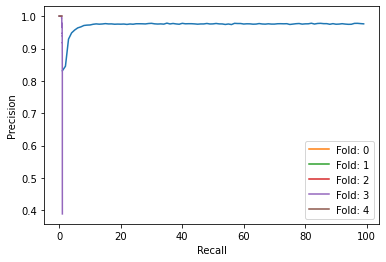

In [7]:
efm = Ethereum_Fraud_Model()
df = efm.df.drop(efm.filtered_colns, axis=1)
print(df.columns)
rfm = Random_Forest_Model(df)
rfm.set_max_depth(100)
rfm.run()

## Model 2. Supervised: Decision Tree (by Akshay)

highest accuracy at depth:  36


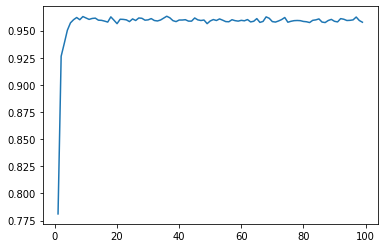

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

df = efm.df.drop(efm.filtered_colns, axis=1)
df.fillna(df.median(), inplace=True)
df.head()

X = df.drop(columns=[TARGET_FEATURE])
Y = df[TARGET_FEATURE]
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.7,random_state=1)

accuracy_dt, max_depth_dt = [] , []
for i in range(1,100):
    clf_r = DecisionTreeClassifier(max_depth=i)
    clf_r = clf_r.fit(train_X,train_Y)
    y_pred = clf_r.predict(test_X)
    accuracy_dt.append(accuracy_score(test_Y,y_pred))
    max_depth_dt.append(i)
    
plt.plot(max_depth_dt,accuracy_dt)
max_value = max(accuracy_dt)
max_index = accuracy_dt. index(max_value)
print('highest accuracy at depth: ',max_depth_dt[max_index])
dtc = DecisionTreeClassifier(max_depth=max_depth_dt[max_index])

accuracy_score:  0.9761300152361605
fraud_precision: [0. 1.]
fraud_recall: [nan  0.]
AUPRC: nan
F1 score:  0.0 

accuracy_score:  0.9791666666666666
fraud_precision: [0. 1.]
fraud_recall: [nan  0.]
AUPRC: nan
F1 score:  0.0 

accuracy_score:  0.9766260162601627
fraud_precision: [0. 1.]
fraud_recall: [nan  0.]
AUPRC: nan
F1 score:  0.0 

accuracy_score:  0.9684959349593496
fraud_precision: [0.10721545 0.80408163 1.        ]
fraud_recall: [1.         0.93364929 0.        ]
AUPRC: 0.8724223714453992
F1 score:  0.8640350877192983 

accuracy_score:  0.8064024390243902
fraud_precision: [1. 1. 1.]
fraud_recall: [1.         0.80640244 0.        ]
AUPRC: 1.0
F1 score:  0.8928270042194093 



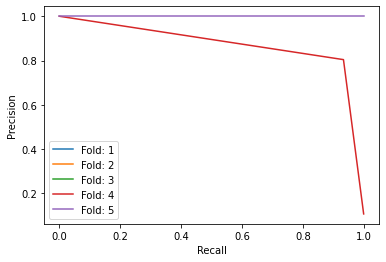

In [15]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
kf.get_n_splits(X, Y)

c=1
for train, test in kf.split(X):
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = Y.iloc[train], Y.iloc[test]
    
    dtc = dtc.fit(X_train,y_train)
    prediction = []
    prediction = dtc.predict(X_test)
    
    accu = accuracy_score(y_test,prediction)
    print("accuracy_score: ",accu)
    
    y_pred = dtc.predict_proba(X_test)
    fraud_precision, fraud_recall, thresholds = precision_recall_curve(y_test, y_pred[:, 1])
    print("fraud_precision:",fraud_precision)
    print("fraud_recall:",fraud_recall)
    print ("AUPRC:", auc(fraud_recall, fraud_precision))
    print("F1 score: ", f1_score(y_pred=prediction, y_true=y_test),'\n')
    temp = 'Fold: '+str(c)
    plt.plot (fraud_recall, fraud_precision,label=temp)
    c=c+1

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Model 3. Unsupervised: GMM (by Pratik)

In [13]:
# GMM
gmm_model = GMM_Model(efm.data.drop(efm.filtered_colns, axis=1))
efm.add_model(gmm_model)
efm.run_model(model_name='GMM')

Model Name: GMM


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,...,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,...,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,...,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,...,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,...,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0


Components: 1
Final threshold: -226.262626
Test Recall Score: 1.000
Test Precision Score: 0.587
Test F1 Score: 0.740
tn, fp, fn, tp: [   0  767    0 1090]
Components: 2
Final threshold: -226.262626
Test Recall Score: 1.000
Test Precision Score: 0.587
Test F1 Score: 0.740
tn, fp, fn, tp: [   0  767    0 1090]
Components: 3
Final threshold: -218.181818
Test Recall Score: 1.000
Test Precision Score: 0.587
Test F1 Score: 0.740
tn, fp, fn, tp: [   0  767    0 1090]
Components: 4
Final threshold: -218.181818
Test Recall Score: 1.000
Test Precision Score: 0.587
Test F1 Score: 0.740
tn, fp, fn, tp: [   0  767    0 1090]


## Model 4. Unsupervised: DBSCAN (by Pratik)

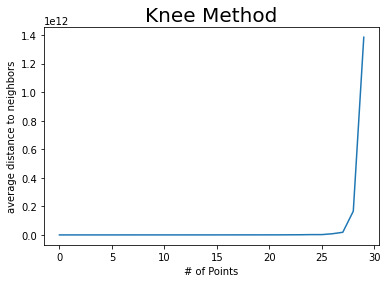

EPS 161353995.6322635
Estimated number of clusters: 4
Estimated number of Noise Points: 21
EPS 176526629.15195802
Estimated number of clusters: 4
Estimated number of Noise Points: 20
EPS 188445633.60408634
Estimated number of clusters: 4
Estimated number of Noise Points: 19
EPS 215962532.82549998
Estimated number of clusters: 4
Estimated number of Noise Points: 16
EPS 222961587.22448573
Estimated number of clusters: 4
Estimated number of Noise Points: 16
EPS 222961587.22448573
Estimated number of clusters: 4
Estimated number of Noise Points: 16
EPS 242515426.7944865
Estimated number of clusters: 4
Estimated number of Noise Points: 15
EPS 400531516.3436608
Estimated number of clusters: 3
Estimated number of Noise Points: 13
EPS 400845951.35748523
Estimated number of clusters: 3
Estimated number of Noise Points: 13
EPS 400845951.35748523
Estimated number of clusters: 3
Estimated number of Noise Points: 13
EPS 466965850.340653
Estimated number of clusters: 3
Estimated number of Noise Poin

In [15]:
# DBSCAN Model
df = efm.data.drop(efm.filtered_colns, axis=1)
dbscan_model = DBSCAN_Model(df)
efm.add_model(dbscan_model)
efm.run_model(model_name='DBSCAN')

# 8. Model Evaluation (by Kenny)

### -------------------- Functions Delarations --------------------

In [4]:
# Helper: compute corresponding f1-score given thresholds
def compute_f1(y_test, y_pred, thresholds):
    scores = []
    for th in thresholds:
        th_y_pred = y_pred.copy()
        
        th_y_pred[th_y_pred >= th] = 0
        th_y_pred[th_y_pred < th] = 1
        scores.append(f1_score(y_test, th_y_pred))
    return scores


def plot_ROC(y_test, y_pred, plt_config, f1=False):
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    scores = []
    if f1:
        scores = compute_f1(y_test, y_pred, thresholds)

    plt.figure(figsize=plt_config['figsize'])
    plt.title('ROC for ' + plt_config['model'])
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0,1], [0,1], 'y--')
    if f1:
        plt.plot(thresholds, scores, 'r')
    plt.ylabel('True Positive Rate / Score')
    plt.xlabel('False Positive Rate / Threshold')
    plt.legend(['ROC', 'Perfect Classifier', 'F1'])
    plt.show()


def plot_PRC(y_test, y_pred, plt_config, f1=False):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

    scores = []
    if f1:
        scores = compute_f1(y_test, y_pred, thresholds)

    plt.figure(figsize=plt_config['figsize'])
    plt.title('PRC for ' + plt_config['model'])
    plt.plot(recall, precision, 'b')
    if f1:
        plt.plot(thresholds, scores, 'r')
    plt.ylabel('Precision / Score')
    plt.xlabel('Recall / Threshold')
    plt.legend(['PRC', 'F1'])
    plt.show()


## Metric 1. ROC w/ F1

In [5]:
# Prepare parameters for ROC

# Uncomment the following when you have data ready

"""
# Get probablistic predictions using a trained model
probs = xgb_c.predict_proba(norm_test_f)
pred = probs[:, 1]

# Customize plot
plt_config = {
    'figsize': (12, 8),
    'model': 'XGB Classifier'
}

# Call the function with your choice of f1 plotting (in the same grapgh)
plot_ROC(y_test, pred, plt_config, f1=True)
"""

"\n# Get probablistic predictions using a trained model\nprobs = xgb_c.predict_proba(norm_test_f)\npred = probs[:, 1]\n\n# Customize plot\nplt_config = {\n    'figsize': (12, 8),\n    'model': 'XGB Classifier'\n}\n\n# Call the function with your choice of f1 plotting (in the same grapgh)\nplot_ROC(y_test, pred, plt_config, f1=True)\n"

## Metric 2. PRC w/ F1

In [6]:
# Prepare parameters for PRC

# Uncomment the following when you have data ready

"""
# Get probablistic predictions using a trained model
probs = xgb_c.predict_proba(norm_test_f)
pred = probs[:, 1]

# Customize plot
plt_config = {
    'figsize': (12, 8),
    'model': 'XGB Classifier'
}

# Call the function with your choice of f1 plotting (in the same grapgh)
plot_PRC(y_test, pred, plt_config, f1=True)
"""

"\n# Get probablistic predictions using a trained model\nprobs = xgb_c.predict_proba(norm_test_f)\npred = probs[:, 1]\n\n# Customize plot\nplt_config = {\n    'figsize': (12, 8),\n    'model': 'XGB Classifier'\n}\n\n# Call the function with your choice of f1 plotting (in the same grapgh)\nplot_PRC(y_test, pred, plt_config, f1=True)\n"